## Table of Contents

Note to reviewers: Click on the hyperlinks below to review each part of the assignment

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Obtain Neighborhoods by Scraping</a>

2. <a href="#item2">Add Geocoding</a>

3. <a href="#item3">Explore and cluster the neighborhoods in Toronto</a>

</font>
</div>

<a id='item1'></a>
# Part 1 Obtain Neighborhoods by Scraping

In [1]:
import pandas as pd
import numpy as np

### Scrape the Neighborhood List from Wikipedia
The provided web page contains 3 tables; the one we need is the first table

In [2]:
df_raw = pd.read_html( 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M') [0]
df_raw.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Clean the data
#### Remove the rows with Burough = 'Not assigned'

In [3]:
df_hoods = df_raw[ df_raw['Borough'] != 'Not assigned']
df_hoods.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [4]:
# Still a problem with one row that has Neighbourhood == Not assigned
df_hoods[ df_hoods.Neighbourhood == 'Not assigned']

,Postcode,Borough,Neighbourhood
8,M7A,Queen's Park,Not assigned


#### Use Burough if Neighborhood == 'Not assigned'
I am doing this before combining rows with the same postal code, because if you combine the rows first (as implied by the instructions), you might get a Neighborhood like 'Not assigned, Mr. Rogers, Boondocks, ...'

In [6]:
#df.Col2 = df.Col1.where(df.Col2 == 'X', df.Col2)

df_hoods.Neighbourhood = df_hoods.Borough.where( df_hoods.Neighbourhood == 'Not assigned', df_hoods.Neighbourhood)

#Now none of the Neighbourhood values are 'Not assigned'
df_hoods[ df_hoods.Neighbourhood == 'Not assigned']

,Postcode,Borough,Neighbourhood


#### Consolidate Neighborhoods from the same Postal Code

Assumptions:
* Postcode, Borough, and Neighbourhood will never be blank
* Postcode will always be a valid CA post code prefix for Toronto
* There will not be two Boroughs with the same Postcode
* There will not be two rows with the same value for Neighbourhood

In [7]:
df_post = df_hoods.groupby(['Postcode', 'Borough'],as_index=False)['Neighbourhood'].agg(','.join)
df_post.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Final Cell
In the last cell of your notebook, use the *.shape* method to print the number of rows of your dataframe.

In [8]:
df_post.shape

(103, 3)

<a id='item2'></a>
# Part 2 Add Geocoding

In [40]:
!pip install geocoder

Apparently, the Google geocoder is not going to work unless you have a Google Could account and an application ID. Without proper credentials, you get the **REQUEST DENIED** error shown below

In [9]:
import geocoder as geo
import requests

In [10]:
# initialize your variable to None
lat_lng_coords = None
postal_code = 'M5A'

# loop until you get the coordinates
# while(lat_lng_coords is None):
g = geo.google('{}, Toronto, Ontario'.format(postal_code))
print( g)
lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

<[REQUEST_DENIED] Google - Geocode [empty]>


TypeError: 'NoneType' object is not subscriptable

The above error is Google telling us that it won't answer unless we give a valid API key.

So we go ahead and use the provided Excel Sheet

In [11]:
df_ll = pd.read_csv('https://cocl.us/Geospatial_data')
df_ll.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
df_hoods.shape

(211, 3)

In [13]:
# Merge neighborhoods (scraped from Wikipedia) with Longitude/Latitude of each Post Code
# have to rename the Postcode column so it is the same in both data frames
df_geo = pd.merge(
    df_post, 
    df_ll.rename(columns={'Postal Code':'Postcode'}), 
    on='Postcode', how='inner')
df_geo.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [14]:
df_geo.shape

(103, 5)

We still have all 103 rows that were scraped from Wikipedia. Now every row has its Longitude and Latitude.

In [16]:
#Find the neighborhoods where the Borough contains 'Toronto'
df_toronto = df_geo[df_geo.Borough.str.contains( "Toronto")].reset_index(drop=True)
df_toronto

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


Define a function to return up to LIMIT venues from Four Square (explore endpoint)

This is the same function that was given in the lab

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
CLIENT_ID = '2DO54SC4HMRSZOCKMQQXKXAYX3XBT4VHQPHOINJBATHGLVTK' # your Foursquare ID
CLIENT_SECRET = 'CJOOZGNPVX2TSGHJF3KBEMU4222XG0IZL4U4HAMLGRVDJXN1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 125
RADIUS = 700

In [19]:
toronto_venues = getNearbyVenues(
    names=df_toronto['Postcode'],
    latitudes=df_toronto['Latitude'],
    longitudes=df_toronto['Longitude']
)

M4E
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6G
M6H
M6J
M6K
M6P
M6R
M6S
M7Y


In [20]:
toronto_venues.shape

(1706, 7)

In [21]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [22]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
M4E,5,5,5,5,5,5
M4K,41,41,41,41,41,41
M4L,17,17,17,17,17,17
M4M,41,41,41,41,41,41
M4N,3,3,3,3,3,3
M4P,9,9,9,9,9,9
M4R,20,20,20,20,20,20
M4S,33,33,33,33,33,33
M4T,3,3,3,3,3,3


In [23]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 uniques categories.


<a id='item3'></a>
# Part 3 Explore and cluster the neighborhoods in Toronto
This is pretty much copy and paste from the lab
## 3. Analyze Each Neighborhood
First, build a dataframe where each venue is one-hot encoded so the columns are the venue category values, and the data contains 1 under the column of it's category

I had to change the first column from 'Neighborhood' back to 'Postcode', because there is a category with the value 'Neighborhood'

So now we end up with 234 columns -- one column for the Postcode of a venue, and 233 columns for each possible venue category.

In [24]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column (as its original title Postcode) back to dataframe
# (This is not the same way it was done in the lab, but it's simpler code)
toronto_onehot.insert(loc=0, column='Postcode', value=toronto_venues['Neighborhood'])

toronto_onehot.head()

,Postcode,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
toronto_grouped = toronto_onehot.groupby('Postcode').mean().reset_index()
toronto_grouped

,Postcode,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,M4E,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.20000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,M4K,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.024390,0.000000,...,0.000000,0.02439,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390
2,M4L,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,M4M,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.048780,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390
4,M4N,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,M4P,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,M4R,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.050000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
7,M4S,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.030303,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,M4T,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,M4V,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.066667,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000


#### Let's confirm the new size
We have one row for each of our selected post codes, one column for the value of the Postcode, and 232 columns for the categories

In [26]:
toronto_grouped.shape

(38, 233)

Let's print each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in toronto_grouped['Postcode']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped.Postcode == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M4E----
                  venue  freq
0  Other Great Outdoors   0.2
1     Health Food Store   0.2
2                   Pub   0.2
3          Neighborhood   0.2
4                 Trail   0.2


----M4K----
                    venue  freq
0        Greek Restaurant  0.22
1             Coffee Shop  0.10
2      Italian Restaurant  0.07
3          Ice Cream Shop  0.05
4  Furniture / Home Store  0.05


----M4L----
            venue  freq
0   Burrito Place  0.06
1             Gym  0.06
2  Sandwich Place  0.06
3    Burger Joint  0.06
4      Steakhouse  0.06


----M4M----
                 venue  freq
0                 Café  0.10
1          Coffee Shop  0.07
2   Italian Restaurant  0.05
3            Gastropub  0.05
4  American Restaurant  0.05


----M4N----
               venue  freq
0               Park  0.33
1           Bus Line  0.33
2        Swim School  0.33
3  Afghan Restaurant  0.00
4        Music Venue  0.00


----M4P----
               venue  freq
0  Food & Drink Shop  0.11
1           

#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Postcode'] = toronto_grouped['Postcode']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Health Food Store,Other Great Outdoors,Neighborhood,Pub,Trail,Event Space,Ethiopian Restaurant,Electronics Store,Discount Store,Falafel Restaurant
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Pizza Place,Bookstore,Brewery,Bubble Tea Shop
2,M4L,Italian Restaurant,Ice Cream Shop,Burger Joint,Burrito Place,Fast Food Restaurant,Liquor Store,Fish & Chips Shop,Sandwich Place,Steakhouse,Sushi Restaurant
3,M4M,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place
4,M4N,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


## 4. Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 5 clusters.

In [104]:
!pip install sklearn

In [30]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [44]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=44).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_


array([9, 3, 3, 0, 5, 4, 3, 3, 7, 3, 2, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       1, 6, 0, 0, 3, 8, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
# add clustering labels
toronto_venues_sorted['Cluster Labels'] = kmeans.labels_
#toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues_sorted.set_index('Postcode'), on='Postcode')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Health Food Store,Other Great Outdoors,Neighborhood,Pub,Trail,Event Space,Ethiopian Restaurant,Electronics Store,Discount Store,Falafel Restaurant,9
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Pizza Place,Bookstore,Brewery,Bubble Tea Shop,3
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,Italian Restaurant,Ice Cream Shop,Burger Joint,Burrito Place,Fast Food Restaurant,Liquor Store,Fish & Chips Shop,Sandwich Place,Steakhouse,Sushi Restaurant,3
3,M4M,East Toronto,Studio District,43.659526,-79.340923,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,5


I noticed that the clustering algorithm picked clusters that contained only 1 or 2 data points. So most zones fell into a single cluster, but the following 5 zones were put into their own clusters.

In [46]:
toronto_merged[toronto_merged['Cluster Labels'] != 9]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Pizza Place,Bookstore,Brewery,Bubble Tea Shop,3
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,Italian Restaurant,Ice Cream Shop,Burger Joint,Burrito Place,Fast Food Restaurant,Liquor Store,Fish & Chips Shop,Sandwich Place,Steakhouse,Sushi Restaurant,3
3,M4M,East Toronto,Studio District,43.659526,-79.340923,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,5
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,Breakfast Spot,Grocery Store,Food & Drink Shop,Clothing Store,Dance Studio,Sandwich Place,Hotel,Gym,Park,Falafel Restaurant,4
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,Coffee Shop,Clothing Store,Yoga Studio,Sporting Goods Shop,Furniture / Home Store,Fast Food Restaurant,Mexican Restaurant,Miscellaneous Shop,Diner,Dessert Shop,3
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,Sandwich Place,Dessert Shop,Café,Italian Restaurant,Pharmacy,Pizza Place,Coffee Shop,Sushi Restaurant,Fried Chicken Joint,Indian Restaurant,3
8,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,Playground,Park,Restaurant,Yoga Studio,Discount Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,7
9,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,Pub,Coffee Shop,Light Rail Station,Liquor Store,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Bagel Shop,Fried Chicken Joint,3
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,Park,Playground,Trail,Building,Yoga Studio,Dive Bar,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,2


In [47]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Markdown, display, HTML

In [48]:
# create map
latitude = 43.6532
longitude = -79.3832
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postcode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# HTML(m._repr_html_())
HTML(map_clusters._repr_html_())

Since Folium maps will not show in Github, I took a screen shot of the map and pasted the image into this markdown cell
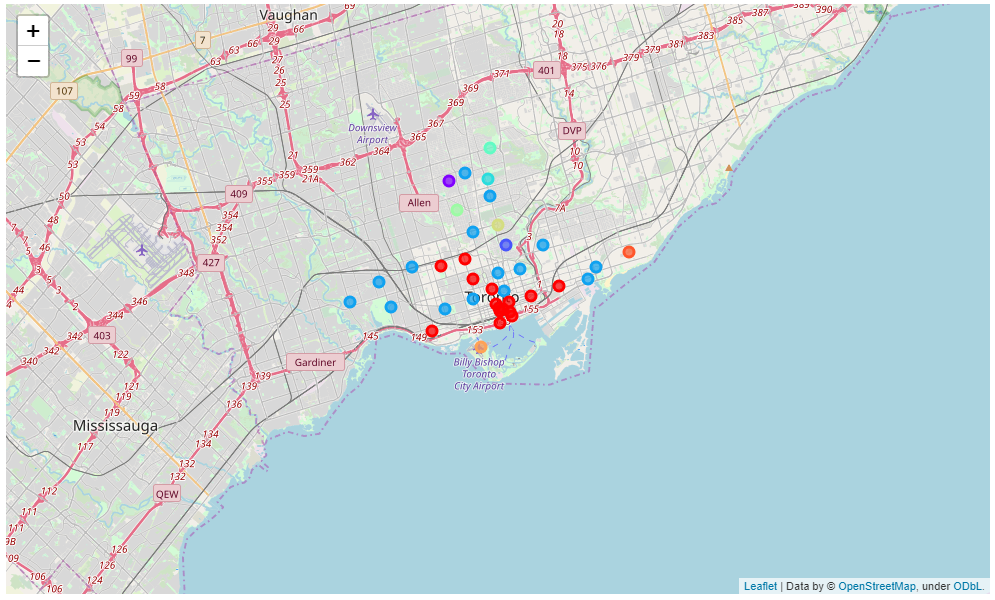

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster

In [49]:
# This loop shows the zones for each cluster, which is an improvement from the code in the lab
# (where each zone was displayed with an separate line of code)
for c in range(kclusters):
    display( Markdown('**Cluster ' + str(c) + '**'))
    display( toronto_merged.loc[toronto_merged['Cluster Labels'] == c, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]])


**Cluster 0**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
3,East Toronto,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place,0
13,Downtown Toronto,Coffee Shop,Park,Café,Bakery,Gym / Fitness Center,Theater,Mexican Restaurant,Pub,Restaurant,Breakfast Spot,0
15,Downtown Toronto,Coffee Shop,Hotel,Restaurant,Café,Italian Restaurant,Bakery,Beer Bar,Breakfast Spot,Gastropub,Cocktail Bar,0
16,Downtown Toronto,Coffee Shop,Cocktail Bar,Beer Bar,Café,Steakhouse,Bakery,Seafood Restaurant,Farmers Market,Cheese Shop,Irish Pub,0
17,Downtown Toronto,Coffee Shop,Italian Restaurant,Sandwich Place,Ice Cream Shop,Café,Burger Joint,Bubble Tea Shop,Spa,Sushi Restaurant,Bar,0
18,Downtown Toronto,Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Asian Restaurant,Restaurant,Cosmetics Shop,Hotel,Burger Joint,0
19,Downtown Toronto,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Brewery,Bakery,Sporting Goods Shop,Pizza Place,Scenic Lookout,0
20,Downtown Toronto,Coffee Shop,Café,Hotel,Italian Restaurant,Restaurant,Bar,American Restaurant,Gym,Gastropub,Deli / Bodega,0
21,Downtown Toronto,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Seafood Restaurant,Deli / Bodega,Bakery,Steakhouse,Gastropub,0
24,Central Toronto,Coffee Shop,Sandwich Place,Café,Pizza Place,History Museum,BBQ Joint,Indian Restaurant,Jewish Restaurant,Liquor Store,Metro Station,0


**Cluster 1**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
22,Central Toronto,Music Venue,Garden,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,1


**Cluster 2**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
10,Downtown Toronto,Park,Playground,Trail,Building,Yoga Studio,Dive Bar,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,2


**Cluster 3**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,East Toronto,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Pizza Place,Bookstore,Brewery,Bubble Tea Shop,3
2,East Toronto,Italian Restaurant,Ice Cream Shop,Burger Joint,Burrito Place,Fast Food Restaurant,Liquor Store,Fish & Chips Shop,Sandwich Place,Steakhouse,Sushi Restaurant,3
6,Central Toronto,Coffee Shop,Clothing Store,Yoga Studio,Sporting Goods Shop,Furniture / Home Store,Fast Food Restaurant,Mexican Restaurant,Miscellaneous Shop,Diner,Dessert Shop,3
7,Central Toronto,Sandwich Place,Dessert Shop,Café,Italian Restaurant,Pharmacy,Pizza Place,Coffee Shop,Sushi Restaurant,Fried Chicken Joint,Indian Restaurant,3
9,Central Toronto,Pub,Coffee Shop,Light Rail Station,Liquor Store,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Bagel Shop,Fried Chicken Joint,3
11,Downtown Toronto,Coffee Shop,Pizza Place,Bakery,Café,Restaurant,Chinese Restaurant,Pub,Italian Restaurant,Park,Playground,3
12,Downtown Toronto,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym,3
14,Downtown Toronto,Coffee Shop,Clothing Store,Cosmetics Shop,Fast Food Restaurant,Café,Bookstore,Japanese Restaurant,Restaurant,Italian Restaurant,Pizza Place,3
26,Downtown Toronto,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Chinese Restaurant,Mexican Restaurant,Dumpling Restaurant,Bar,Bakery,Coffee Shop,Donut Shop,3
31,West Toronto,Pharmacy,Supermarket,Bakery,Liquor Store,Music Venue,Park,Café,Middle Eastern Restaurant,Bar,Bank,3


**Cluster 4**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
5,Central Toronto,Breakfast Spot,Grocery Store,Food & Drink Shop,Clothing Store,Dance Studio,Sandwich Place,Hotel,Gym,Park,Falafel Restaurant,4


**Cluster 5**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
4,Central Toronto,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,5


**Cluster 6**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
23,Central Toronto,Park,Trail,Bus Line,Sushi Restaurant,Jewelry Store,Yoga Studio,Doner Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,6


**Cluster 7**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
8,Central Toronto,Playground,Park,Restaurant,Yoga Studio,Discount Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,7


**Cluster 8**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
27,Downtown Toronto,Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Bar,Coffee Shop,8


**Cluster 9**

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,East Toronto,Health Food Store,Other Great Outdoors,Neighborhood,Pub,Trail,Event Space,Ethiopian Restaurant,Electronics Store,Discount Store,Falafel Restaurant,9


#### Analysis
Mostly, the clustering algorithm seems to pick outliers. So most of the clusters have only a single neighborhood or zone. I ran this experiment dozens of times, and I almost always got each cluster except one to have only a single zone. For example, the airport (Cluster 8) always seems to be in its own cluster.

When I increased the value of K to be high enough to weed out the outliers, the algorithm split the zones into two roughly equal clusters (which appear as Cluster 0 and Cluster 3 above). This was not always consistent, but it seems that if I use a value of K around 10, you can start to see the split into two clusters each with more than one or 2 neighborhoods. 

If you look at the map, you can see that the algorithm seems to be differentiating between downtown and the outer parts of Toronto (still called Toronto, so not proper suburbs).